# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [83]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as ss
import prettytable
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from wordcloud import WordCloud 
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os

In [7]:
#Loading the dataset that we cleaned in TSNE project
df = pd.read_csv(r'C:\Users\nihar\affrd_cleaned_preprocessed.csv')

In [8]:
df['Score'].value_counts() #counting the number of positive and negative datapoints

positive    307061
negative     57110
Name: Score, dtype: int64

In [9]:
#randomly sampling positive and negative datapoints and from the dataframe 'df' and creating new data frame total_points
positive_points = df[df['Score'] == 'positive'].sample(n=2500, random_state=0)#randomly sampling 20k positive points
negative_points = df[df['Score'] == 'negative'].sample(n=2500, random_state=0)# randomly sampling 20k negative points
total_points = pd.concat([positive_points, negative_points])#concatenating the positive_points and negative_points dataframe

# Sorting based on time
sorted_data = total_points.sort_values('Time', #Here we are sorting filtered_data according to Time in 
                                       axis = 0,    #- ascending order so that we can do time based splitting later.
                                     inplace = False, #inpace = false because we dont want to make modifications in-
                                      #- fitered data rather we want to keep filtered_data preserved and store the modified-
                                      #- data in sorted_data
                                    kind = 'quicksort',
                                     na_position = 'last')
sorted_data['Score'].value_counts()
sorted_data.to_csv('sorted_data_df.csv')
sorted_data = pd.read_csv('sorted_data_df.csv')

In [10]:
x = sorted_data['CleanedText']

### 1. TFIDF on Amazon Fine Food Reviews

In [35]:
#tf-idf on train dataset
vectorizer = TfidfVectorizer()#defining our tf-idf model and considering only those words which occur more than 10-
#times in our document
model = vectorizer.fit(x)#Here we are learning the internal parameters (i.e vocabulary) of our train dataset-
#- (i.e. review text)
print(vectorizer.vocabulary_) #visualizing the parameters learnt (i.e vocabulary)

{'beetlejuic': 719, 'movi': 5534, 'cant': 1238, 'watch': 9384, 'time': 8689, 'one': 5926, 'funiest': 3420, 'ever': 2870, 'made': 5047, 'mix': 5423, 'strang': 8195, 'realiti': 6905, 'stori': 8180, 'along': 231, 'romanc': 7234, 'alec': 186, 'baldwin': 602, 'geena': 3489, 'davi': 2108, 'funni': 3424, 'thing': 8628, 'world': 9593, 'live': 4923, 'dead': 2118, 'recent': 6929, 'deceas': 2139, 'handbook': 3836, 'wait': 9341, 'hous': 4108, 'year': 9658, 'haunt': 3890, 'peopl': 6251, 'come': 1697, 'tri': 8839, 'break': 1016, 'cover': 1917, 'take': 8451, 'place': 6394, 'tim': 8688, 'burton': 1135, 'excel': 2902, 'job': 4522, 'see': 7477, 'definit': 2180, 'guilti': 3776, 'pleasur': 6423, 'often': 5899, 'think': 8630, 'suppos': 8349, 'like': 4875, 'film': 3133, 'help': 3963, 'cast': 1307, 'make': 5079, 'solid': 7887, 'rewatch': 7158, 'vehicl': 9220, 'also': 239, 'steadi': 8113, 'feel': 3079, 'great': 3701, 'product': 6659, 'valu': 9188, 'sens': 7509, 'abil': 10, 'frighten': 3361, 'delight': 2205, '

### 1.1 Taking top features from TFIDF

In [44]:
list_1=[]
for i in range(len(model.get_feature_names())):
    list_1.append((model.get_feature_names()[i],model.idf_[i]))

df_1=pd.DataFrame(list_1,columns=['feature_name','idf_score'])

In [45]:
df_2=df_1.sort_values(['idf_score'])[0:3000]
df_2.head()

,feature_name,idf_score
4875,like,2.090844
8487,tast,2.104629
6659,product,2.332764
5926,one,2.409968
3615,good,2.428150


In [46]:
df_2.reset_index(inplace=True)
df_2.drop(columns=['index'],inplace=True)
df_2.head()

,feature_name,idf_score
0,like,2.090844
1,tast,2.104629
2,product,2.332764
3,one,2.409968
4,good,2.428150


### 1.2 Creating cooccurrence matrix

In [47]:
#Generate the Co-Occurence Matrix
def get_coOccuranceMatrix(X_train, top_features, window): #window = 2 means 2 on either side of the given word. Lets look at an example. data = [a,b,c,d,e,f,g,h],
    print("Generating the Co Occurence Matrix....")       #if window = 2, for letter c, we will have neighborhood = [a,b,c,d,e]. for f -> [d,e,f,g,h]
    dim=top_features.shape[0]
    square_matrix = np.zeros((dim,dim),int)
    
    values = [i for i in range(0,top_features.shape[0])]  #Contains all the top IDF Scores as values.
    keys = [str(i) for i in top_features['feature_name']]    #Contains all the corresponding features names as keys.
    lookup_dict = dict(zip(keys,values))                  #We will use this dictionary as a look up table 

    top_words= keys
    
    #Processing each reviews to build the co-occurence Matrix
    for reviews in tqdm(X_train):
        #Split each review into words
        words = reviews.split()
        lnt = len(words)
        for i in range(0,len(words),1):
            idx_of_neigbors= []
            if((i-window >= 0) and (i+window < lnt)):
                idx_of_neigbors = np.arange(i-window,i+window+1)
            elif((i-window < 0) and (i+window < lnt)): 
                idx_of_neigbors = np.arange(0, i+window+1)
            elif((i-window >= 0) and (i+window >= lnt)):
                idx_of_neigbors = np.arange(i-window, lnt)
            else:
                pass
            #nei = [words[x] for x in idx_of_neigbors]
            #print(words[i],"---------",nei)
            #print(idx_of_neigbors)
            
            for j in idx_of_neigbors:
                if((words[j] in top_words) and (words[i] in top_words)):
                    row_idx = lookup_dict[words[i]]     #Get the index of the ith word from the lookup table
                    col_idx = lookup_dict[words[j]]     #Get the index of the jth word from the lookup table
                    square_matrix[row_idx,col_idx] += 1 #If word[i] and word[j] occurs in a neighbourhood of 5, there co occurence will be increases by one.
                else:
                    pass
                    
    #Fill all the diagonal elements of the co-occurence matrix with 0, as co-occurence of a word with itlself is always zero.                
    np.fill_diagonal(square_matrix, 0) 
    print("Co Occurence Matrix is generated....")      
    
    #Create a co-occurence dataframe.
    co_occur_df=pd.DataFrame(data=square_matrix, index=keys, columns=keys)
    return co_occur_df

co_occur_matrix = get_coOccuranceMatrix(x, df_2, window=2)

#Save the co occurence matrix.
co_occur_matrix.to_csv('cooccurence.csv')

Generating the Co Occurence Matrix....


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:38<00:00, 129.41it/s]


Co Occurence Matrix is generated....


In [49]:
co_occur_matrix.head()

,like,tast,product,one,good,tri,flavor,love,use,would,...,anybodi,oxid,electrolyt,cardamom,teenag,disclaim,weruva,excus,anyhow,prescript
like,0,578,82,88,70,61,128,29,48,77,...,0,0,0,0,0,0,0,1,0,0
tast,578,0,69,67,230,49,109,52,29,50,...,2,0,1,1,0,0,0,0,0,0
product,82,69,0,54,91,55,22,57,112,69,...,0,0,1,1,0,0,0,1,1,0
one,88,67,54,0,54,103,70,35,51,35,...,0,0,0,0,0,0,0,0,1,0
good,70,230,91,54,0,35,99,25,30,35,...,1,0,1,1,0,0,0,1,0,0


### 1.3 Finding optimal value for number of components (n) to be retained. (Its like in PCA where we have to determine the number of dimensions that explain maximum variance)

2999


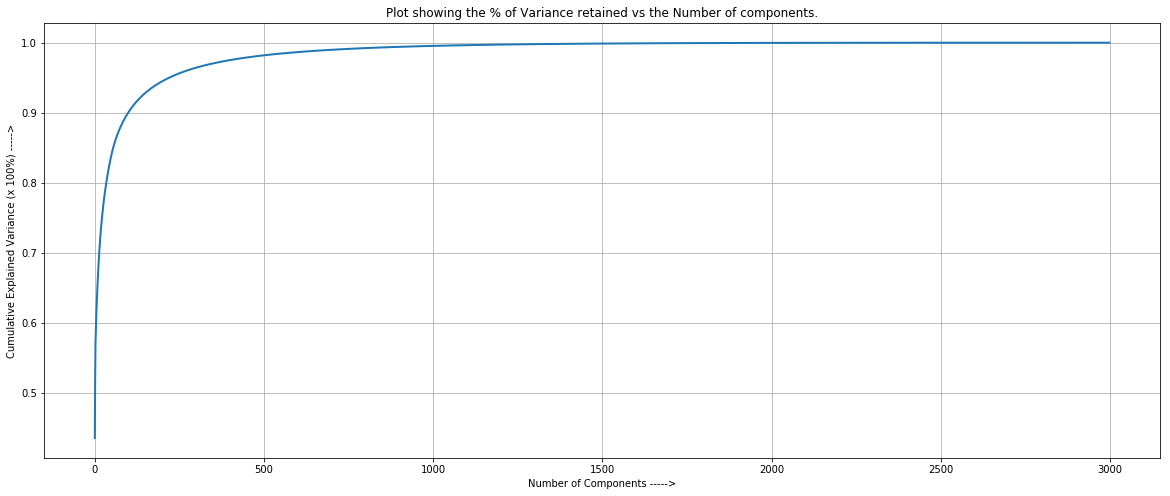

In [52]:
n = co_occur_matrix.shape[0]-1
print(n)
#Inititalize the truncated SVD object.
svd = TruncatedSVD(n_components=n, 
                   algorithm='randomized', 
                   n_iter=10, 
                   random_state=0)
data=svd.fit_transform(co_occur_matrix)

cum_var_explained = np.cumsum(svd.explained_variance_ratio_)

# Plot the SVD spectrum
plt.figure(1, figsize=(20, 8))
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.title('Plot showing the % of Variance retained vs the Number of components.')
plt.xlabel('Number of Components ----->')
plt.ylabel('Cumulative Explained Variance (x 100%) ----->')
plt.show()

### Observation
<pre>As we can see from the above plot, we can preserve the maximum amount of variance by reducing the dimensions to 1000, i.e. n_components=500 makes the model retain almost 100% of the features.</pre>

### 1.4 Applying KMeans clustering

In [55]:
#Now we will break Cooccurrence matrix (i.e. Matrix Factorization) into U*sigma*V.T using truncated SVD
svd = TruncatedSVD(n_components=1000,
                   algorithm='randomized', 
                   random_state=0,
                   n_iter=10)

U = svd.fit_transform(co_occur_matrix)
VT = svd.components_
Sigma = np.zeros((1000,1000),int)
print("U = {}, Sigma = {}, V.T = {}".format(U.shape,Sigma.shape,VT.shape)) #MF Formulae for SVD : X = U * sigma * V.T => U contains <u1,u2,u3...ud> -> Word vectors corresponding to the top words

U = (3000, 1000), Sigma = (1000, 1000), V.T = (1000, 3000)


In [58]:
### 2.1 K-Means on BOW
k=[1,2,3,4,5,6,7,8]
dic=dict()
for i in k:
    clf=KMeans(n_clusters=i)
    clf.fit(U)
    dic[i] = clf.inertia_

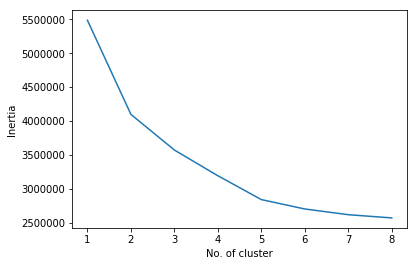

In [59]:
plt.plot(list(dic.keys()), list(dic.values()))
plt.xlabel("No. of cluster")
plt.ylabel("Inertia")
plt.show()

### Observation
<pre>Optimal value of k=5</pre>

In [62]:
clf = KMeans(n_clusters = 5)
clf.fit(U)
pred=clf.predict(U)

In [63]:
#Plot each cluster features in a cloud
def plot_cluster_cloud(features, coef):
    coef_df = pd.DataFrame(coef, columns = features)
    print(len(coef_df))
    # Create a figure and set of 15 subplots because our k range is in between 
    fig, axes = plt.subplots(5, 3, figsize = (30, 20))
    fig.suptitle("Top 20 words for each cluster ", fontsize = 50)
    cent = range(len(coef_df))
    for ax, i in zip(axes.flat, cent):
        wordcloud = WordCloud(background_color = "white").generate_from_frequencies(coef_df.iloc[i,:].sort_values(ascending = False)[0:20])
        ax.imshow(wordcloud)
        ax.set_title("Cluster {} word cloud".format(i+1), fontsize = 30)
        ax.axis("off")
    plt.tight_layout()
    fig.subplots_adjust(top = 0.90)
    plt.show()

In [79]:
top_feats = [str(i) for i in df_2['feature_name']]
labels = list(set(clf.labels_)) #clf.labels_ Gives the label of each cluster to which a particular word belongs to
clusters_list = []
for i in labels:
    temp=[]
    for word_idx in range(clf.labels_.shape[0]):# clf.labels_.shape[0]=3000
        if (clf.labels_[word_idx] == i): #clf.labels_[word_idx] gives the cluster to which a word belongs to
            #word_idx is the row no. of each word in clf_labels_
            temp.append(top_feats[word_idx])
    clusters_list.append(temp)

### 1.5 WordCloud of clusters obtained in above section

In [85]:
stop = set(stopwords.words('english'))

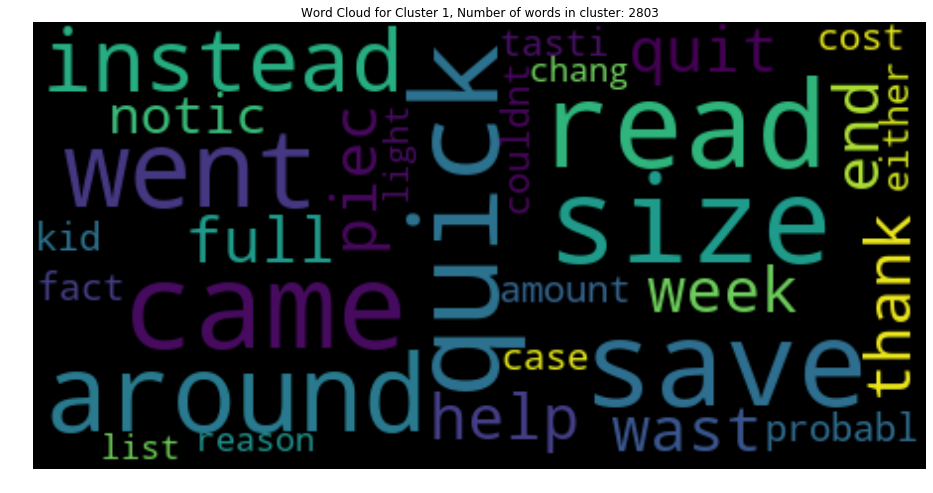

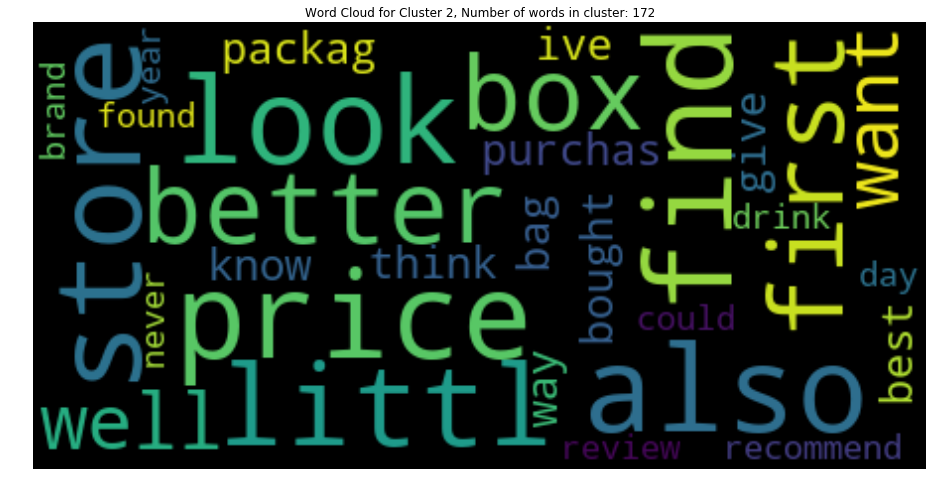

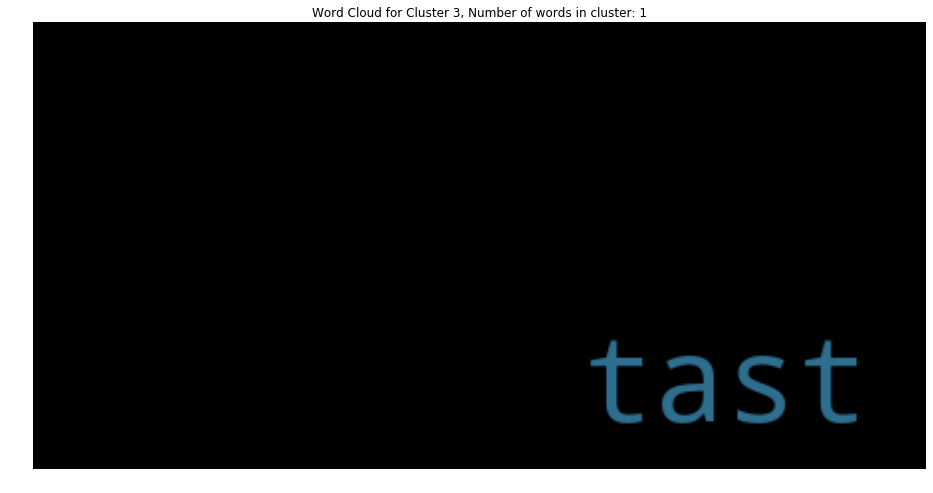

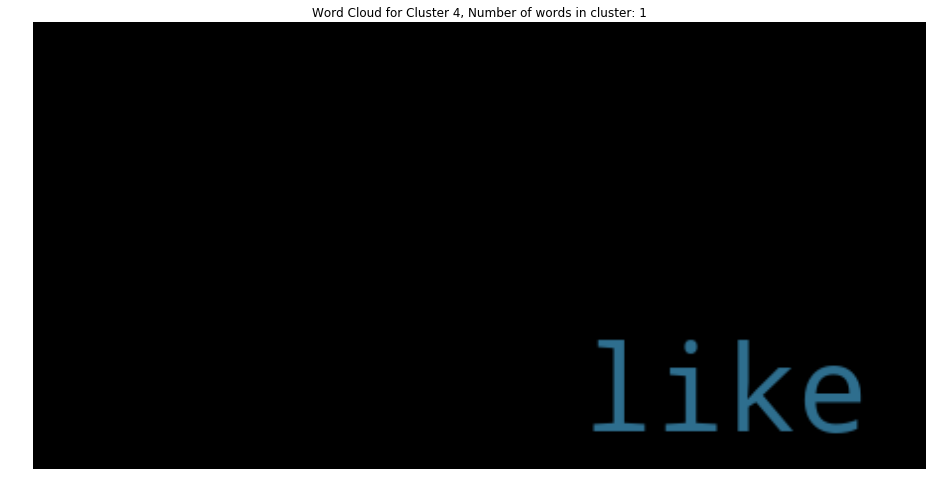

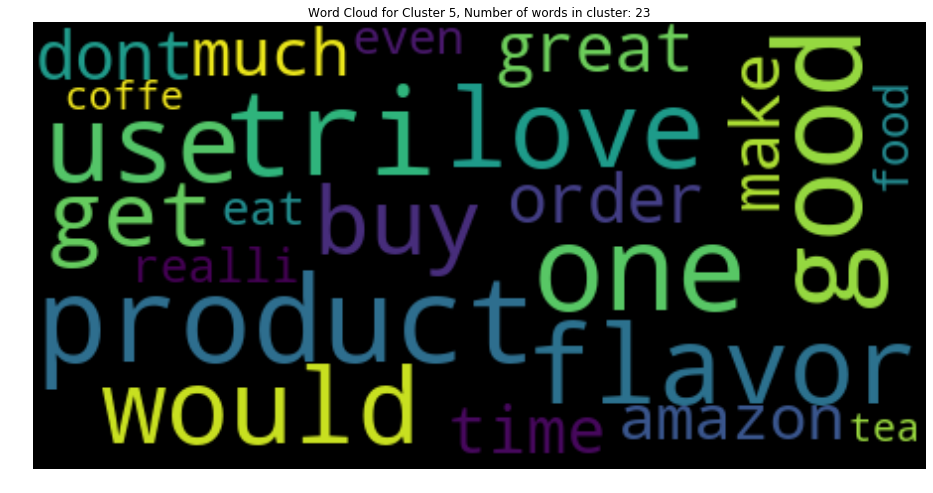

In [87]:
#Function to draw word clouds for each clusters.

def word_clouds(clusters_list):
    '''This method is used to draw word clouds for the top words which are groped together as different clusters.'''
    
    cluster_count = 1
    for cluster in clusters_list:
        word_corpus = ""
        for word in cluster:
            word_corpus = word_corpus + " " + word

        #lower max_font_size
        #we will select the maximum number of words from each cluster to be 20 to see the cluster at one go and understand briefly on what it means and how it has clustered data.
        wordcloud = WordCloud(width=450, height=225, max_words=30, random_state=5, stopwords=stop, background_color='black', max_font_size=60, font_step=1, mode='RGB', repeat=False)
        wordcloud.generate(word_corpus)
        plt.figure(figsize=(16,9))
        plt.title("Word Cloud for Cluster {}, Number of words in cluster: {}".format(cluster_count,len(cluster)))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
        cluster_count+=1

#Draw word cloud for each clusters
word_clouds(clusters_list)

### 1.6 Function that returns most similar words for a given word.

In [88]:
def cosine_sim(data_point1, data_point2):
    from numpy.linalg import norm
    cos_dis = np.dot(data_point1, data_point2)/(norm(data_point1)*norm(data_point2))
    return (1-cos_dis) #cosine distance = 1 - cosine similarity

'''#Function to obtain Euclidean distances between any two vectors.
def get_euclidean_distance(data_point1, data_point2):
    distance = 0
    for i in range(len(data_point1)):
        distance += ((data_point1[i] - data_point2[i]) ** 2)
    distance = distance ** 0.5
    return distance
'''

#Function to obtain the 10 nearest words(semantically by meaning) for any input word, i.e. 
#a function that takes a word and returns the most similar words using cosine similarity between the vectors.
def get_nearest_words(U,top_features,input_word):
    print("Words related to '{}':".format(input_word))
    #Stemming and stopwords removal
    from nltk.stem.snowball import SnowballStemmer
    sno = SnowballStemmer(language='english')
    input_word=(sno.stem(input_word.lower()))
    print(input_word)
    top_words=list(top_features['feature_name'])
    if input_word in top_words:
        for i in range(len(top_words)):
            if input_word == top_words[i]:
                index = i
                
        similarity_values = []
        for i in range(U.shape[0]): #U contains word vectors corresponding to all words.
            similarity_values.append(cosine_sim(U[i], U[index]))
            
        sorted_indexes = np.array(similarity_values).argsort()


        
        #Display top 10 nearest words to the input words in a PrettyTable format.
        sim_words = []
        sim_scores = []
        for i in range(1, 11):
            sim_words.append(top_words[sorted_indexes[i]])
            sim_scores.append(1-similarity_values[sorted_indexes[i]])
        
        from prettytable import PrettyTable
        table = PrettyTable()
        table.add_column("Similar Words", sim_words)
        table.add_column("Similarity Scores", sim_scores)
        print(table)

    else:
        print("This word is not present in the vocabulary of top words.")
        
    print('\n')
        
#Get 10 nearest words for any given words.
get_nearest_words(U,df_2,"amazon")
get_nearest_words(U,df_2,"coffee")
get_nearest_words(U,df_2,"meat")
get_nearest_words(U,df_2,"cat")
get_nearest_words(U,df_2,"product")
get_nearest_words(U,df_2,"vanilla")
get_nearest_words(U,df_2,"bacon")
get_nearest_words(U,df_2,"like")

Words related to 'amazon':
+---------------+--------------------+
| Similar Words | Similarity Scores  |
+---------------+--------------------+
|     onlin     | 0.7663350884956404 |
|    compani    | 0.6779742635576446 |
|    product    | 0.6482982619702113 |
|      item     | 0.6464183490044554 |
|     never     | 0.6333625840256074 |
|      case     | 0.6149139710092496 |
|     place     | 0.6097298329200627 |
|     receiv    | 0.6028262417347089 |
|    purchas    | 0.5949436478676021 |
|     price     | 0.5899716657907583 |
+---------------+--------------------+


Words related to 'coffee':
+---------------+--------------------+
| Similar Words | Similarity Scores  |
+---------------+--------------------+
|     realli    | 0.7222263324621886 |
|      tea      | 0.7066002617609447 |
|      also     | 0.7015199121800267 |
|     stuff     | 0.6852166326446195 |
|      one      | 0.6820511866354068 |
|     still     |  0.67737688239406  |
|     flavor    | 0.6772966538562674 |
|      n

# [6] Conclusions

In [0]:
# Please write down few lines about what you observed from this assignment. 
# Also please do mention the optimal values that you obtained for number of components & number of clusters.